In [1]:
import numpy as np
from fastdtw import fastdtw
import matplotlib.pyplot as plt

def generate_archive(num_curves=100, min_length=100, max_length=1000, n_features=3):
    archive = []
    for _ in range(num_curves):
        length = np.random.randint(min_length, max_length + 1)
        features = simulate_curve(length=length, n_features=n_features)
        archive.append(features)
    return archive

def plot_archive(archive):
    n_features = archive[0].shape[1]

    _, axs = plt.subplots(n_features, 1, figsize=(10, 3 * n_features), sharex=True)
    if n_features == 1:
        axs = [axs]

    for i in range(n_features):
        for curve in archive:
            axs[i].plot(curve[:, i], alpha=0.7)
        axs[i].set_title(f"Feature {i+1}")
        axs[i].set_ylabel("Value")
    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

def simulate_curve(length=500, n_features=3, explosion_start_ratio=0.8):
    t = np.linspace(0, 1, length)
    explosion_start = explosion_start_ratio

    features = []
    for _ in range(n_features):
        noise = 0.02 * np.random.randn(length)

        explosion = np.exp(t - explosion_start)
        explosion = explosion - explosion[int(explosion_start * length)]
        explosion = np.clip(explosion, 0, None)

        c, factor = np.random.uniform(0.1, 2), np.random.uniform(5, 15)
        feature_curve = np.exp(c*t + factor*explosion) + noise
        features.append(feature_curve)

    features = np.vstack(features).T
    return features

np.random.seed(42)

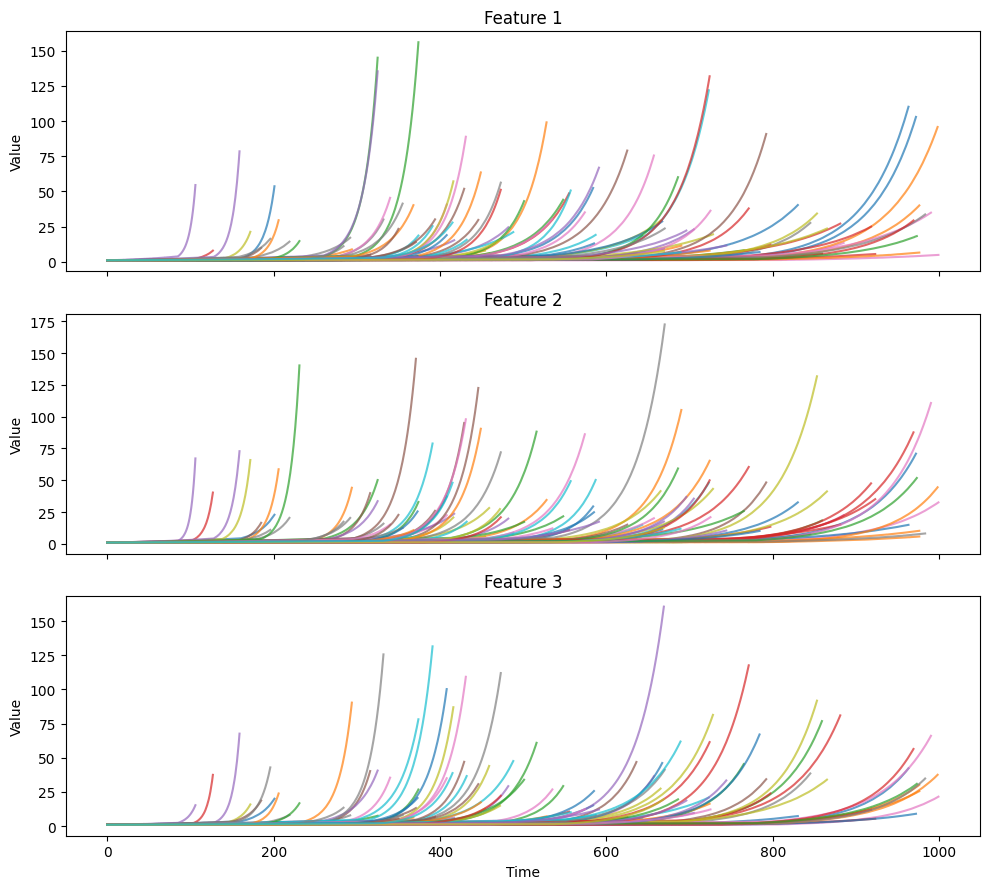

In [2]:
archive = generate_archive(100)
plot_archive(archive)

In [3]:
current_time = np.random.randint(100, 500)
partial_curve = simulate_curve()[:][:current_time]

In [4]:
def estimate_rul_by_similarity(archive, partial_curve):
    partial_len = len(partial_curve)
    best_dist = np.inf
    best_idx = -1
    for idx, curve in enumerate(archive):
        if len(curve) < partial_len:
            continue
        dist, _ = fastdtw(partial_curve[:partial_len], curve[:partial_len], dist=euclidean_dist)
        if dist < best_dist:
            best_dist = dist
            best_idx = idx
    estimated_rul = len(archive[best_idx]) - partial_len
    return estimated_rul, archive[best_idx], best_idx

def euclidean_dist(a, b):
    return np.linalg.norm(a - b)


estimated_rul, best_curve, best_idx = estimate_rul_by_similarity(archive, partial_curve)

print(f"Indice curva più simile: {best_idx}")
print(f"RUL stimata al timestep {len(partial_curve)}: {estimated_rul:.2f}")

Indice curva più simile: 19
RUL stimata al timestep 487: 2.00


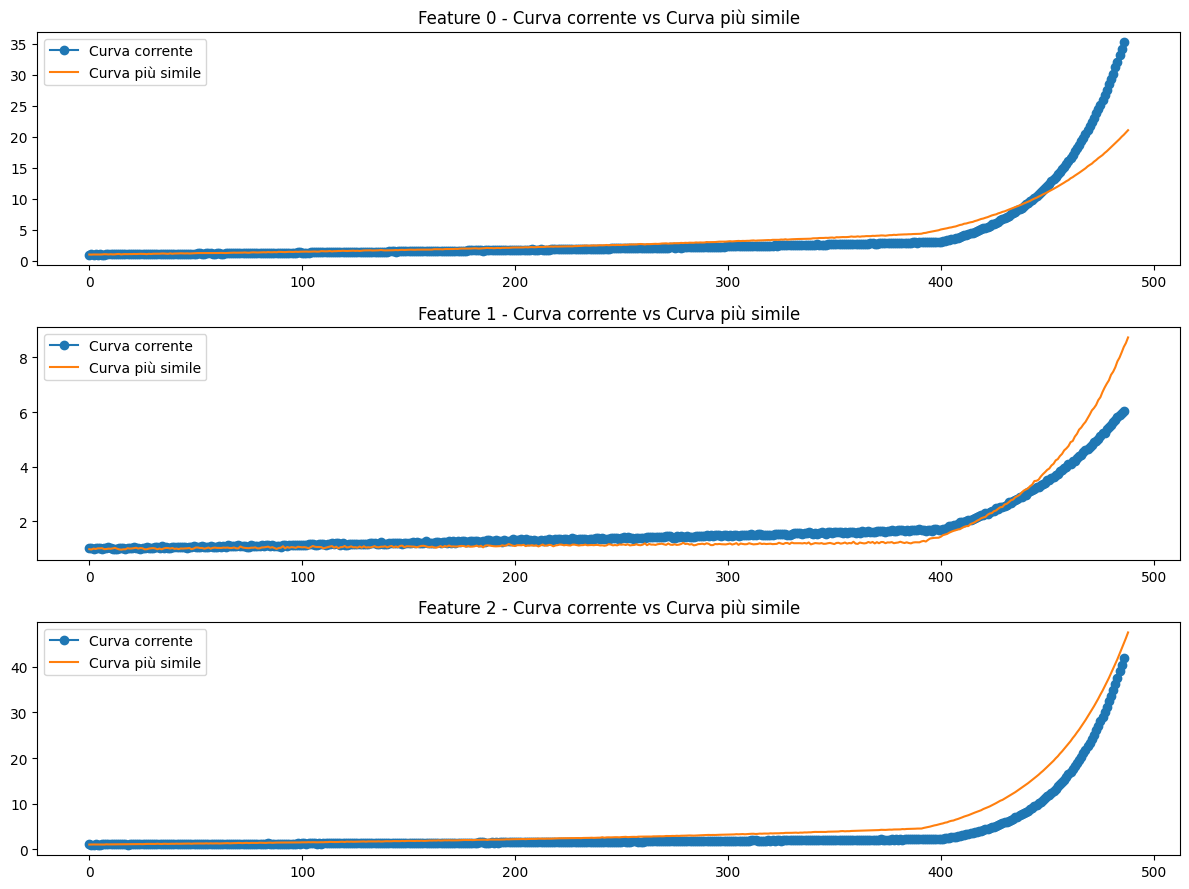

In [5]:
n_features = partial_curve.shape[1]

plt.figure(figsize=(12, 3 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.title(f"Feature {i} - Curva corrente vs Curva più simile")
    plt.plot(partial_curve[:, i], "-o", label="Curva corrente")
    plt.plot(best_curve[:, i], label="Curva più simile")
    plt.legend()
plt.tight_layout()
plt.show()